In [361]:
import random 
from tqdm.notebook import tqdm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn import model_selection, metrics, preprocessing 
import copy 
from torch_geometric.utils import degree 

import torch 
from torch import nn, optim, Tensor 

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip 
from torch_geometric.nn.conv.gcn_conv import gcn_norm 
from torch_geometric.nn.conv import MessagePassing 
from torch_geometric.typing import Adj 


In [362]:
# download dataset
# https://grouplens.org/datasets/movielens/
# "Small: 100,000 ratings and 3,600 tag applications appliedd to 
# 9,000 movies by 600 users. Last update 9/2018"
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-email/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [363]:
!ls ml-latest-small


README.txt   links.csv    movies.csv   ratings.csv  tags.csv


In [364]:
# read data in pandas data frame , do a quick eda 
# due to large movieId range, not suitable for embedding lookup 
# so need to do dod some pre-processing
rating_df = pd.read_csv(rating_path)

print(rating_df.head())
print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))
rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [365]:
# use label encoder for this purpose 
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [366]:
# print out 
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [367]:
# look at value distribution, check where is a good threshold value, 3.5
rating_df.rating.value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [368]:
# convert data frame into the edge index format
# load edges between users and movies 
def load_edge_csv(df, 
                 src_index_col,
                 dst_index_col,
                 link_index_col,
                 rating_threshold=3):
    '''Loads csv containing edges between users and items 
    
        Args:
            src_inddex_col (str): column name of users 
            dst_index_col (str): column name of items 
            link_index_col (str): column name of user item interaction 
            rating_threshold (int, optional): Threshold to determine positivity fo edge, default to 4
 
       Returns:
            List of list: edge_index -- 2 by N matrix containing the nodde ids of N user-item edges 
            N here is the number of interactions
'''
    
    edge_index=None 

    # Constructing C00 format edge_index from input rating events 

    # get user_ids from rating events in the ordder of occurance 
    src = [user_id for user_id in df['userId']]
    # get movie_id from rating events in the order of occurance 
    dst = [(movie_id) for movie_id in df['movieId']]

    # apply rating threshold 
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_index = [[],[]]
    for i in range(edge_attr.shape[0]):
           if edge_attr[i]:
               edge_index[0].append(src[i])
               edge_index[1].append(dst[i])
    return edge_index

In [369]:
edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=3.5,
)
print(f"{len(edge_index)} x {len(edge_index[0])}")
# COO, row and col for 2

2 x 48580


In [370]:
# Convert to tensor 
# We use LongTensor here because the .propagate() method in the model needs 
# either LongTensor or SparseTensor 
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [371]:
# Note: this is the total num_users and num_movies before we apply the rating_threshold
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())
num_users, num_movies

(610, 9724)

In [372]:
# do train test split 
num_interactions = edge_index.shape[1]

#split the edges of the graph using a 80/10/10 train/validation/test split 
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices,
                                              test_size=0.2,
                                              random_state=1)

# can see in plot
val_indices, test_indices = train_test_split(test_indices, 
                                            test_size = 0.5,
                                            random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]


In [373]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))  # total number of nodes 
print(torch.unique(train_edge_index[0]).size())  # unique num of from nodes 
print(torch.unique(train_edge_index[1]).size())  # unique num of to nodes     

num_users 610, num_movies 9724, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])
10334
torch.Size([609])
torch.Size([5676])


In [374]:
# helper function 
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros(num_users, num_movies)
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1 
                   
    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies, num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [375]:
# helper function n
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                          col=input_edge_index[1],
                                          sparse_sizes=((num_users + num_movies), num_users+num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [376]:
# convert from r_mat (interaction matrix) edge index to addjacency matrix'
# edge index so we can feedd it to model 
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [377]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


In [378]:
# helper function for training and compute BPR loss
# since this is a self-supervised learning, we are relying on the graph 
# structure itself and we don't have label other than the graph structure 
# so we need the following function which random samples a mini-batch 
# of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    '''Randomly samples indices of a minibatch given an adjacency matrix
    
    Args:
        batch_size (int): minibatch size 
        edge_index (torch.Tensor): 2 by N list of edges
    Returns:
        tuple: 
    '''
    # structured_negative_sampling is a pyG library 
    # Samples a negative edge :obj:`(i,k)` for every positive edge 
    # :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns
    # it as a tuple of the form :obj:`(i,j,k)
    #
    #    >>> edge_index = torch.as_tensor([[0, 0, 1, 2],
    #                                      [0, 1, 2, 3]])
    #    >>> structured_negative_sampling(edge_index)
    #    (tensor([0, 0, 1, 2]), tensor([0, 1, 2, 3]), tensor([2, 3, 0, 2]))
    edges = structured_negative_sampling(edge_index)
    
    # 3 x edge_index_len
    edges = torch.stack(edges, dim=0)
    
    # here is when we actually perform the batch sample 
    # return a k sized list of population elements chosen with replacemnt 
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]
    
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# Implement LightGCN

In [379]:
# define LightGCN model
class LightGCN(MessagePassing):
    '''LightGCN Model as proposed in https://arxiv.org/aba/2002.02126
    '''
    def __init__(self, num_users,
                num_items,
                embedding_dim=64, # define the embedding vector length for each node 
                K=3,
                add_self_loops=False):
        '''Initialize LightGCN Model
        
        Args: 
            num_users (int): Number of users 
            num_items (int): Number of items 
            embedding_dim (int, optional): Dimensionality of embeddings, Default to 8
            K (int, optional): Number of message passing layers, Default to 3
            add_self_loops (bool, optional): Whether to add self loops for message passing, Default to False
        '''
        super().__init__()
        self.num_users = num_users 
        self.num_items = num_items 
        self.embedding_dim = embedding_dim 
        self.K = K
        self.add_self_loops = add_self_loops 

        # define user and item embedding for direct lookup 
        # embedding dimension: num_user/num_item x embedding_dim 

        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance 
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        '''Forwardd propagation of LightGCN Model 
        
        Args:
            eddge_index (SparseTensor): adjacency matrix
            
        Returns: 
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        '''
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                  add_self_loops=self.add_self_loops)
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])
        embs = [emb_0] # save the layer emb to the embs list 
        emb_k = emb_0
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
    
        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1)
        
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items])

        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    

In [380]:
#initialize the model 
layers = 3
model = LightGCN(num_users=num_users,
                num_items=num_movies,
                K=layers)

# Loss function

In [381]:
def bpr_loss(users_emb_final,
            users_emb_0,
            pos_items_emb_final,
            pos_items_emb_0,
            neg_items_emb_final,
            neg_items_emb_0,
            lambda_val):
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) + 
                            pos_items_emb_0.norm(2).pow(2) +
                            neg_items_emb_0.norm(2).pow(2))  # L2 loss
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predictedd score of negative samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predictedd score of negative samples
    
    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
    
    loss = bpr_loss + reg_loss 
    
    return loss

In [382]:
# generate dictionary of positive items for each user 
# args: edge_index (torch.Tensor): 2 by N list of edges 
# returns: dict: user -> list of positive items for each 
def get_user_positive_items(edge_index):
    #key: user_id, val: item_id list 
    user_pos_items = {}
    
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
            
        user_pos_items[user].append(item)
    return user_pos_items

In [383]:
# compute recall@K andd precision@K
# args: 
# groundTruth: (list[list[long]]): list of lists of item_ids, containing highly rated items of each user
#              in other words, this is the list of true_relevant_items for each user 
# r: (list[list[boolean]]): list of lists indicating whether each top k item recommended ot each user 
# k: (int): determine the top k items to compute precision and recall on 
# return: tuple: recall @ k, precision @ k 

def RecallPrecision_AtK(groundTruth, r, k):
    # number of correctly predictionn items per user
    # -1 here means I want to sum at the inner most dimensions
    num_correct_pred = torch.sum(r, dim=-1)
    # number of items liked by each user in nthe test set 
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k 
    return recall.item(), precision.item()

In [384]:
# compute NDCG@K, Normalized Discounted Cululative Gain (NDCG) @ k
# 
# args: 
# groundTruth (list): list of lists containing highly rated items of each user 
# r (list): list of lists indicating whether each top k item recommended to each user
#           is a top k ground truth item or not 
# k (int): determines the top k items to compute ndcg on 
#
# returns: 
# float: ndcg @ k
#
def NDCGatK_r(groundTruth, r, k):
    assert len(r) == len(groundTruth)
    test_matrix = torch.zeros([len(r), k])
    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r + 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg 
    ndcg[torch.isnan(ndcg)] = 0 
    return torch.mean(ndcg).item()

    
    

In [385]:
# wrapper function to get evaluation matrics 
# compute the evaluation metrics: recall, precision, and ndcg @ k 
# args: 
#     model (LightGCN): lightgcn model
#     edge_index (torch.Tensor): 2 by N list of edges for split to evaluate 
#     exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluatio 
#     k (int): determines the top k items to compute metrics on 
# returns:
#     tuple: recall @ k, precision @ k, ndcg @ k
def get_metrics(model, 
               input_edge_index, # adj_mat based edge index
               input_exclude_edge_indices, #adj_mat based exclude edge inde 
               k):
    # get the embeding tensor at layer 0 after training 
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight 
    
    # convert adj_mat basedd edge index to r_mat basedd edge index so we have 
    # the first list being user_idds and second list being item_ids for the edge index 
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # This is to exclude the edges we above seen before in our predictedd interaction matrix (r_mat_rating)
    # e.g. for validation set, we want to exclude all the edges in training set 
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                           for exclude_edge_index in input_exclude_edge_indices]
    
    # Generate predicted interaction matrix (r_mat_rating)
    # (num_users x 64) dot_product (num_item x 64).T
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    
    # shape: num_users x num_item
    rating = r_mat_rating
    
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index 
        # it's a dict: user -> positive item list 
        user_pos_items = get_user_positive_items(exclude_edge_index)
        
        # get coordinates of all edges to exclude 
        exclude_users = []
        exclude_items = []
        for user,items in user_pos_items.items():
            # [user] * len(item) can give us [user1, use1, user1...] with len of len(item)
            # this makes easier to do the masking below 
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        # set the excluded entry in the rat_mat_rating matrix to a very small number 
        rating[exclude_users, exclude_items] = -(1 << 10)
    # get the top k recommended items for each user 
    _, top_K_items = torch.topk(rating, k=k)
    
    # get all unique users in evaluated split 
    users = edge_index[0].unique()
    
    # dict of user -> pos_item list 
    test_user_pos_items = get_user_positive_items(edge_index)
    
    # convert test user pos items dictionary into a list of lists 
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users] 
    
    # r here is "pred_relevant_items n actually_relevant_items" list for each user 
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        # list of Booleans to store whether or not a given item in the top_K_items for a given user 
        # is also present in user_true_relevant_item 
        # this is later on used to compute n_rel_and_rec_k 
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))
    
    recall, precision = RecallPrecision_AtK(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)
    
    return recall, precision, ndcg
    

In [386]:
# wrappeer function to evaluate model 
''' Evaluate model loss and metrics including recall, precision, ndcg @ k

    args:
        model: (LightGCN), lightGCN, model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate 
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate 
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation 
        k (int): determins the top k items to compute metrics on 
        lambda_val (float): determine lambda for bpr loss
    returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k 
    '''
def evaluation(model,
              edge_index, # adj_mat based edge index 
              exclude_edge_indices, # adj_mat based exclude edge index 
              k, 
              lambda_val
              ):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
    
    loss = bpr_loss(users_emb_final, 
                   users_emb_0,
                   pos_items_emb_final,
                   pos_items_emb_0,
                   neg_items_emb_final,
                   neg_items_emb_0,
                   lambda_val).item()
    recall, precision, ndcg = get_metrics(model, 
                                         edge_index,
                                         exclude_edge_indices,
                                         k)
    return loss, recall, precision, ndcg

# Training
Your test set performance should be in line with the following (K=20):
Recall@K 0.13, Precision@K: 0.045; NDCG@K:0.10
        

In [403]:
# define constants 
#ITERATIONS = 10000
#ITERATIONS = 500
EPOCHS = 10
ITERATIONS = 500
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-5
# LAMBDA = 1/2

In [404]:
# setup 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)


Using device cpu.


In [405]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    
    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    
    # This is to push tensor to device so fi we use GPU
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
    # we needd layer0 embeddings andd the final embeddings (computedd from 0...K layer) for BPR loss computing 
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
    
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [406]:
# training loop 
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation
    users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 = get_embs_for_bpr(model, train_edge_index)
    
    # loss computation
    train_loss = bpr_loss(users_emb_final,
                         users_emb_0,
                         pos_items_emb_final,
                         pos_items_emb_0,
                         neg_items_emb_final,
                         neg_items_emb_0,
                         LAMBDA)
    
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # validation set 
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                          val_edge_index, 
                                                          [train_edge_index],
                                                          K,
                                                          LAMBDA
                                                          )
            #print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)}")
            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)} val_loss: {round((val_loss), 5)} \
            val_recall: {round(recall, 5)} val_precision: {round(precision, 5)} val_ndcg {round(ndcg, 5)}")
            # print(round((val_loss), 5))
            # train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
            
        model.train()
        
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/500 [00:00<?, ?it/s]

[Iteration 0/500] train_loss: -1.97078 val_loss: -1.39213             val_recall: 0.03746 val_precision: 0.01447 val_ndcg 0.00553
[Iteration 200/500] train_loss: -11.68912 val_loss: -7.47             val_recall: 0.06147 val_precision: 0.02224 val_ndcg 0.01071
[Iteration 400/500] train_loss: -32.40762 val_loss: -21.39549             val_recall: 0.08977 val_precision: 0.0311 val_ndcg 0.01487


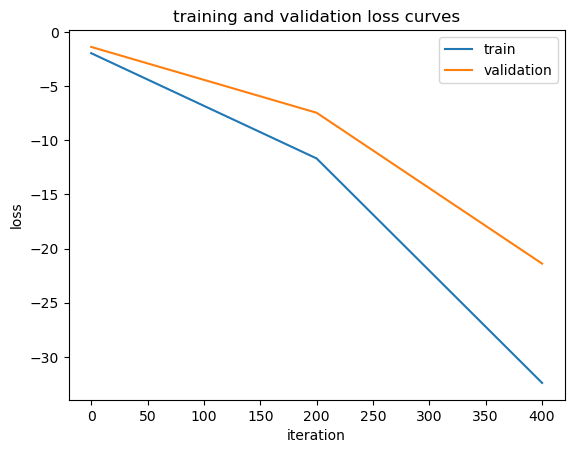

In [407]:
# Let's plot it 
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

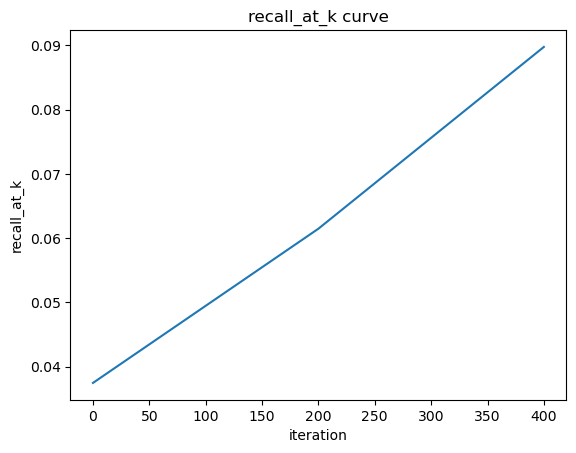

In [408]:
# recall_at_k curves, line is not curve due to small number of trainings
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curve')
plt.show()

In [412]:
# evaluate on test set 
model.eval()
test_edge_index = test_edge_index.to(device)
test_loss, test_recall, test_precision, test_ndcg = evaluation(model,
                                                              test_edge_index,
                                                              [train_edge_index, val_edge_index],
                                                              K,
                                                              LAMBDA
                                                              )
print(f"[test loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K} {round(test_precision, 5)}, test_ndcg@{K} {round(test_ndcg, 5)}]")

[test loss: -30.56348, test_recall@20: 0.10539, test_precision@20 0.03469, test_ndcg@20 0.01663]
